In [334]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as mtcs
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import sklearn.feature_selection as fs
import sklearn.neural_network as nn

from sklearn.pipeline import Pipeline
from sklearn.linear_model.base import BaseEstimator
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, save
from tqdm import tqdm
from statsmodels.stats.weightstats import ztest
from xgboost import XGBClassifier
from tempfile import mkdtemp
from scipy.stats import wilcoxon

%matplotlib inline
output_notebook()

Loading BokehJS ...

# Common functions

In [236]:
#Cell: 1

def weight_init(name, shape):
    return tf.get_variable(name, initializer=tf.random_normal(shape=shape,
                                                              stddev=0.1))
def bias_init(name, shape):
    return tf.get_variable(name, initializer=tf.constant(0.1, shape=shape))

def elastic_net(x, l1, l2):
    return l1 * ( (1-l2) / 2 * tf.norm(x, 2) ** 2 + 
                   l2 * tf.norm(x, 1))

def batch_data(*matrxs, batch_size):
    for batch_i in range(matrxs[0].shape[0] // batch_size):
        yield tuple(x.iloc[batch_i * batch_size : (batch_i + 1) * batch_size] 
                     for x in matrxs)
        
def split_data3(data, train_size=0.5, test_size=0.25, validate_size=0.25):
    train_data, test_val_data = ms.train_test_split(data, train_size=train_size)
    test_data, val_data = ms.train_test_split(test_val_data,
                                              train_size=test_size / (test_size+validate_size))
    
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    validate_X, validate_y = val_data.drop('y', axis=1), val_data[['y']]
    
    return (train_X, train_y, test_X, test_y, validate_X, validate_y)

def split_data2(data, train_size, test_size):
    train_data, test_data = ms.train_test_split(data, train_size=train_size,
                                                stratify=data.y, shuffle=True)
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    
    return (train_X, train_y, test_X, test_y)
    
def drop_correllated_ftrs(data, corr):
    y = data.y
    data = data.drop('y', axis=1)
    
    corr_matrix = data.corr(corr).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    const = list(filter(lambda col: len(data[col].unique()) == 1, data.columns ))
    to_drop += const
    data = data.drop(to_drop, axis=1)
    
    data['y'] = y
    print(f"Dropped {len(to_drop)} correlated features")
    
    return data

def pp_pipeline(data):
    scaler = pp.StandardScaler()
    
    data_pp = scaler.fit_transform(data)
    
    data_pp = pd.DataFrame(data_pp,
                        index=data.index,
                        columns=data.columns)
    
    #restore target
    data_pp.y = data.y
    
    data_pp = drop_correllated_ftrs(data_pp, 'pearson')
    data_pp = drop_correllated_ftrs(data_pp, 'spearman')
    
    return data_pp

def main_metric(y_true, y_pred):
    return mtcs.accuracy_score(y_true, y_pred)

# Data uploading&preview

In [101]:
data = _data_ = pd.read_csv('./data/train.csv')

data

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0
3,43.976744,7.648293,3.837209,14.392765,168.885456,175.277251,1.622298,7.629033,12.180817,9.070719,...,5.879135,4.280132,4.563045,5.007714,5.159773,5.393628,5.640132,5.472271,5.741399,0.0
4,24.320988,6.534011,3.567901,8.913580,163.076959,96.019681,1.380679,6.566695,4.417010,8.058783,...,8.148663,4.624973,5.173321,5.720312,6.259342,6.626469,7.062406,7.472998,7.829842,0.0
5,20.924051,6.134299,3.037975,6.506329,165.707039,82.761541,1.381957,6.187547,4.684599,7.660347,...,6.087556,4.430817,4.820282,5.183187,5.595176,5.489454,5.604998,5.847522,5.987080,0.0
6,34.150000,6.740695,3.733333,10.214815,164.252922,135.639059,1.620887,6.781702,8.631090,8.248393,...,6.198225,4.471639,4.801970,5.237107,5.493833,5.573816,5.764799,5.865760,5.998937,0.0
7,23.833333,6.395508,3.141026,8.717949,163.221967,94.106131,1.435936,6.443753,5.834402,7.904135,...,6.582328,4.600158,5.032071,5.499726,5.978728,5.995208,6.179952,6.364051,6.481290,0.0
8,32.380952,6.152543,2.857143,6.402116,164.380868,128.391104,1.687697,6.232890,4.476844,7.736528,...,0.000000,3.449988,3.865979,4.506730,4.765906,4.965028,3.840795,3.595598,0.000000,0.0
9,45.228571,6.608449,3.714286,9.180952,159.167580,180.141749,1.981354,6.690537,8.428546,8.221041,...,5.214936,3.828641,4.234107,4.682131,4.890349,5.192957,5.342334,5.402677,5.303305,0.0


[ 0.  1.]


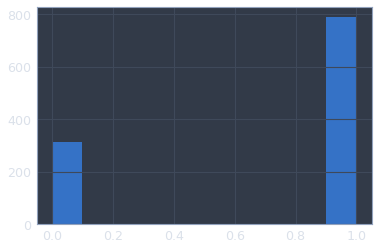

In [102]:
print(data.y.unique())
plt.hist(data.y);

In [103]:
print(data.isnull().sum().sum())

num_1 = data[data.y == 1].shape[0] 
num_0 = data[data.y == 0].shape[0]

print(num_1, num_0, num_1 / (num_0 + num_1))

0
790 315 0.7149321266968326


In [104]:
data = pp_pipeline(_data_)

data_X = data.drop('y', axis=1)
data_y = data[['y']]

Dropped 1279 correlated features
Dropped 20 correlated features


In [105]:
(train_X, train_y, test_X, test_y) = split_data2(data, train_size=0.8, test_size=0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Feature selection

## DFS

In [183]:
#Cell: 1

class DFS(BaseEstimator):
    def __init__(self, layers_sizes=[128, 64, 2], batch_size=32, lambda1=1e-3, lambda2=1.,
                 alpha1=1e-3, alpha2=0., num_epochs=10, verbose=0, N=None, 
                 dropout_rate=1.):
        self.layers_sizes = layers_sizes
        self.num_layers = len(layers_sizes)
        self.batch_size = batch_size
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.num_epochs = num_epochs
        self.verbose = verbose
        self.N = N
        self.dropout_rate = dropout_rate
        
        
    def fit(self, X, y, test_data=None):
        self._build_graph_(X.shape[1])
        self.features = X.columns #Persisting for `select_most_important_ftrs`
        self.sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(self.num_epochs):
            X_cur = X.sample(frac=1, random_state=epoch_i)
            y_cur = y.sample(frac=1, random_state=epoch_i)
            epoch_loss = 0
            for batch_X, batch_y in batch_data(X_cur, y_cur, 
                                               batch_size=self.batch_size):
                train_loss, _ = self.sess.run([self.total_loss, self.train_step],
                                               feed_dict = {self.x: batch_X,
                                                            self.y: batch_y,
                                                            self.dropout_rate_ph: self.dropout_rate})
                epoch_loss += train_loss
            epoch_loss /= X.shape[0] // self.batch_size
            
            train_predict = self.predict(X_cur)
            train_accuracy = mtcs.accuracy_score(y_cur, train_predict)
            
            if self.verbose:
                if test_data is not None:
                    test_X, test_y = test_data
                    test_predict = self.predict(test_X)
                    test_accuracy = mtcs.accuracy_score(test_y, test_predict)
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}."
                          f"Train accuracy: {train_accuracy}. Test accuracy: {test_accuracy}.")
                else:
                    print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}. "
                          f"Train accuracy: {train_accuracy}.")
                
        return self
       
    
    def predict_proba(self, X):
        predictions_proba = self.sess.run(self.predictions, 
                                          feed_dict={self.x: X,
                                                     self.dropout_rate_ph: 1.})
        
        return predictions_proba
    
    
    def predict(self, X):
        predictions_proba = self.predict_proba(X)
        
        return list(map(np.argmax, predictions_proba))
    
    
    def get_features_weights(self):
        weights = self.sess.run(self.features_weights)
        
        return weights
    
    
    def select_most_important_ftrs(self, N):
        weights = self.get_features_weights()
        feature_weight = sorted(zip(weights, self.features), 
                                key=lambda x: abs(x[0]))
        
        return map(lambda x: x[1], feature_weight[-N:])
    
    
    def select_most_important_ftrs_thresh(self, thresh=0.1):
        weights = self.get_features_weights()
        feature_weight = filter(lambda x: x[0] >= thresh,
                                zip(weights, self.features))
        
        return map(lambda x: x[1], feature_weight)
    
    
    def transform(self, X, N=None, threshold=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        elif self.N:
            features = list(self.select_most_important_ftrs(self.N))
        else:
            features = list(self.select_most_important_ftrs_thresh(threshold))
        
        return X[features]
    
     
    def _build_graph_(self, num_features):
        tf.reset_default_graph()
        
        ###Placeholders 
        x = tf.placeholder(tf.float32, [None, num_features], 'x_ph')
        y = tf.placeholder(tf.int32, [None], 'y_ph')
        dropout_rate_ph = tf.placeholder(tf.float32, None, 'dropout_rate')
        
        ###Weights initialization
        w = tf.get_variable("dfs_features_weight", 
                            initializer = tf.constant(1., shape=[num_features]))
        self.layers_sizes = [num_features] + self.layers_sizes
        W, b = [], []
        for layer_i in range(self.num_layers):
            W.append(weight_init(f"layer_{layer_i}_weights",
                                 shape=[self.layers_sizes[layer_i],
                                        self.layers_sizes[layer_i+1]]))
            b.append(bias_init(f"layer_{layer_i}_bias",
                               shape=[self.layers_sizes[layer_i+1]]))
        
        ###Input transformations
        logits = x * w #feature selection
        for layer_i in range(self.num_layers):
            if layer_i != self.num_layers - 1:
                logits = tf.nn.dropout(
                            tf.nn.relu(tf.matmul(logits, W[layer_i]) + b[layer_i]),
                            keep_prob=dropout_rate_ph)
            else:
                logits = tf.matmul(logits, W[layer_i]) + b[layer_i]
        predictions = tf.nn.softmax(logits)
            
        ###Loss calculation
        logloss = tf.reduce_sum(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                                       logits=logits))
        w_loss = elastic_net(w, self.lambda1, self.lambda2)
        W_loss = tf.reduce_sum([elastic_net(W_i, self.alpha1, self.alpha2) for W_i in W])
        
        total_loss = tf.reduce_sum(logloss + w_loss + W_loss)
        
        ###Optimizer
        train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)
        
        self.x = x
        self.y = y
        self.dropout_rate_ph = dropout_rate_ph
        self.predictions = predictions
        self.total_loss = total_loss
        self.train_step = train_step
        self.features_weights = w
        

In [ ]:
#Cell: 2

param_grid = [
    {
        'layers_sizes': [[64, 64, 32, 2]],
        'lambda1': np.arange(5e-3, 1e-1, 5e-3),
        'alpha1': np.arange(1e-2, 1, 5e-1),
        'num_epochs': [200],
        'dropout_rate': [0.25],
    }
]

grid_dfs = ms.GridSearchCV(DFS(), param_grid, scoring='accuracy', verbose=100)

grid_dfs.fit(train_X, train_y.y)

In [241]:
grid_dfs.best_estimator_, grid_dfs.best_score_

(DFS(N=None, alpha1=0.01, alpha2=0.0, batch_size=32, dropout_rate=0.25,
   lambda1=0.069999999999999979, lambda2=1.0,
   layers_sizes=[225, 64, 64, 32, 2], num_epochs=200, verbose=0),
 0.8744343891402715)

In [ ]:
dfs = DFS([64, 64, 32, 2], lambda1=0.07, alpha1=1e-2,  num_epochs=200, 
          verbose=True, dropout_rate=0.25)

dfs.fit(train_X, train_y['y'], test_data=(test_X, test_y))

0.904977375566


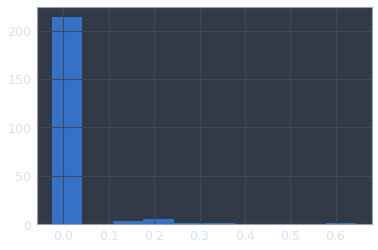

In [166]:
print(mtcs.accuracy_score(test_y, dfs.predict(test_X)))
plt.hist(dfs.get_features_weights());

## Lasso

In [261]:
#Cell: 1
class LassoFS(BaseEstimator):
    def __init__(self, N=None, C=1.):
        self.N = N
        self.est = lm.LogisticRegression(penalty='l1', C=C)
        self.C = C
    
    def fit(self, X, y):
        self.est.fit(X, y)
        self.features = X.columns
        
        return self
    
    
    def transform(self, X, N=None):
        if N:
            features = list(self.select_most_important_ftrs(N))
        else:
            features = list(self.select_most_important_ftrs(self.N))
        
        return X[features]

    
    def predict(self, X):
        return self.est.predict(X)
    
    
    @property
    def coef_(self):
        return self.est.coef_


    def select_most_important_ftrs(self, N):
        feature_weight = sorted(zip(self.est.coef_[0], self.features),
                                key=lambda x: abs(x[0]))

        return list(map(lambda x: x[1], feature_weight[-N:]))
    
    def select_most_important_ftrs_thresh(self, thresh=0.15):
        weights = self.est.coef_[0]
        feature_weight = filter(lambda x: x[0] >= thresh,
                                zip(weights, self.features))
        
        return map(lambda x: x[1], feature_weight)

In [262]:
#Cell: 2
param_grid = [
    {
        'C': np.arange(0.1, 2, 0.1)
    }
]

grid_lasso = ms.GridSearchCV(LassoFS(), param_grid, scoring='accuracy', verbose=100)

grid_lasso.fit(train_X, train_y.y)

Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV] C=0.1 ...........................................................
[CV] ................... C=0.1, score=0.847457627118644, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8406779661016949, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.8707482993197279, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[CV] C=0.2 ...........................................................
[CV] ................... C=0.2, score=0.847457627118644, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[CV] C=0.2 ........................................

[CV] .................. C=1.4, score=0.8406779661016949, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.7s remaining:    0.0s
[CV] C=1.4 ...........................................................
[CV] .................. C=1.4, score=0.8707482993197279, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    1.8s remaining:    0.0s
[CV] C=1.5 ...........................................................
[CV] ................... C=1.5, score=0.847457627118644, total=   0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.8s remaining:    0.0s
[CV] C=1.5 ...........................................................
[CV] .................. C=1.5, score=0.8406779661016949, total=   0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    1.8s remaining:    0.0s
[CV] C=1.5 ...........................................................
[CV] .................. C=1.5, score=0.8707482993197279, total=   0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45

GridSearchCV(cv=None, error_score='raise', estimator=LassoFS(C=1.0, N=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=100)

In [244]:
grid_lasso.best_estimator_, grid_lasso.best_score_

(LassoFS(C=0.10000000000000001, N=None), 0.8529411764705882)

0.83257918552


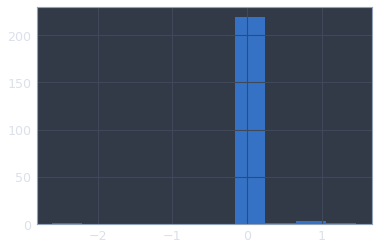

In [245]:
lassofs = LassoFS(C=.1);
lassofs.fit(train_X, train_y.y);
print(mtcs.accuracy_score(test_y, lassofs.predict(test_X)))
plt.hist(lassofs.coef_[0]);

# Classification models

## Random Forest

In [342]:
est = ens.RandomForestClassifier()

train_X = dfs.transform(train_X, 500)
test_X = dfs.transform(test_X, 500)

est.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Gradient Boosting

In [ ]:
def select_most_important_ftrs(est, features, N):
    feature_weight = sorted(zip(est.coef_[0], features),
                            key=lambda x: abs(x[0]))
    
    return list(map(lambda x: x[1], feature_weight[-N:]))

In [128]:
est = XGBClassifier(n_estimators=1000, n_jobs=40, silent=False)

est.fit(train_X_dfs, train_y, verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=40, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

## MLP

Instead of writing MLP from scratch we use DFS model with lambda1 and alpha1 equals to zero

# Hyperparameters optimization

In [252]:
NUM_FEATURES = list(range(2, 40, 2))

In [226]:
def evaluate(main_model, feature_selector, param_grid, 
             X, y, scoring='accuracy', caching=False):

    if main_model is not None:
        pipeline_list = [('select_ftrs', feature_selector),
                         ('main', main_model)]
    else:
        pipeline_list = [('select_ftrs', feature_selector)]

    if caching:
        pipeline = Pipeline(pipeline_list, memory=mkdtemp())
    else:
        pipeline = Pipeline(pipeline_list)
    
    grid = ms.GridSearchCV(pipeline, cv=ms.StratifiedKFold(n_splits=5,
                                                           shuffle=True),
                           n_jobs=1, param_grid=param_grid,
                           verbose=100, scoring=scoring)

    grid.fit(X, y)
    
    return grid

In [212]:
all_scores = dict()

In [257]:
##### DFS + RandomForest #####
param_grid = [
    {
        'select_ftrs__layers_sizes': [[64, 64, 32, 2]],
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__lambda1': [0.07],
        'select_ftrs__num_epochs': [100],
        'select_ftrs__dropout_rate': [0.25],
    }
]

all_scores['DFS + RF'] = evaluate(ens.RandomForestClassifier(),
                                  DFS(), param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8280542986425339, total=  13.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.832579185520362, total=  14.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.1s remaining:    0.0s
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ft

[CV]  select_ftrs__N=8, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8506787330316742, total=  14.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.8min remaining:    0.0s
[CV] select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8823529411764706, total=  14.3s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  5.0min remaining:    0.0s
[CV] select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs_

[CV]  select_ftrs__N=16, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8733031674208145, total=  14.2s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  9.6min remaining:    0.0s
[CV] select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8778280542986425, total=  14.3s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  9.8min remaining:    0.0s
[CV] select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

[CV]  select_ftrs__N=24, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8687782805429864, total=  14.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 14.4min remaining:    0.0s
[CV] select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8642533936651584, total=  14.2s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed: 14.7min remaining:    0.0s
[CV] select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

[CV]  select_ftrs__N=32, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8914027149321267, total=  14.5s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 19.3min remaining:    0.0s
[CV] select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8642533936651584, total=  14.1s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 19.5min remaining:    0.0s
[CV] select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

In [260]:
##### DFS + Gradient Boosting #####
param_grid = [
    {
        'select_ftrs__layers_sizes': [[64, 64, 32, 2]],
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__lambda1': [0.07],
        'select_ftrs__num_epochs': [100],
        'select_ftrs__dropout_rate': [0.25],
    }
]

all_scores['DFS + GB'] = evaluate(XGBClassifier(),
                                  DFS(), param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8461538461538461, total=  13.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8687782805429864, total=  14.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.4s remaining:    0.0s
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_f

[CV]  select_ftrs__N=8, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8461538461538461, total=  14.2s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.8min remaining:    0.0s
[CV] select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8778280542986425, total=  14.3s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  5.1min remaining:    0.0s
[CV] select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs_

[CV]  select_ftrs__N=16, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8687782805429864, total=  14.5s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  9.7min remaining:    0.0s
[CV] select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8959276018099548, total=  14.6s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:  9.9min remaining:    0.0s
[CV] select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

[CV]  select_ftrs__N=24, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8733031674208145, total=  14.8s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 14.6min remaining:    0.0s
[CV] select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8823529411764706, total=  14.4s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed: 14.8min remaining:    0.0s
[CV] select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

[CV]  select_ftrs__N=32, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8687782805429864, total=  14.1s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 19.5min remaining:    0.0s
[CV] select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8552036199095022, total=  14.1s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 19.7min remaining:    0.0s
[CV] select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

In [258]:
##### LassoFS + RandomForest #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES,
     'select_ftrs__C': np.arange(1.) 
    }
]

all_scores['Lasso + RF'] =  evaluate(ens.RandomForestClassifier(),
                                     LassoFS(), param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] select_ftrs__C=0.0, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.0, select_ftrs__N=2, score=0.7963800904977375, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.0, select_ftrs__N=2, score=0.8371040723981901, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.0, select_ftrs__N=2, score=0.8144796380090498, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.0, select_ftrs__N=2, score=0.7330316742081447, total=   0.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s 

[CV]  select_ftrs__C=0.0, select_ftrs__N=16, score=0.8733031674208145, total=   0.1s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.6s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=16, score=0.8687782805429864, total=   0.1s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    4.8s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=16, score=0.8280542986425339, total=   0.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    4.9s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=16, score=0.8552036199095022, total=   0.2s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    5.1s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=16, score=0.859

[CV]  select_ftrs__C=0.0, select_ftrs__N=30, score=0.8959276018099548, total=   0.1s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    9.1s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=30 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=30, score=0.8642533936651584, total=   0.1s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    9.2s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=30 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=30, score=0.8506787330316742, total=   0.1s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    9.3s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=30 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=30, score=0.8687782805429864, total=   0.1s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    9.4s remaining:    0.0s
[CV] select_ftrs__C=0.0, select_ftrs__N=30 ...........................
[CV]  select_ftrs__C=0.0, select_ftrs__N=30, score=0.855

In [263]:
##### LassoFS + GradientBoosting #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES,
     'select_ftrs__C': [.1],
     'main__random_state': [10]
    }
]

all_scores['Lasso + GB'] = evaluate(XGBClassifier(),
                                    LassoFS(), param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2 .....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2, score=0.8642533936651584, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2 .....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2, score=0.8597285067873304, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2 .....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2, score=0.8597285067873304, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2 .....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=2, score=0.8

[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=14, score=0.9049773755656109, total=   0.2s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    5.4s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=14 ....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=14, score=0.8280542986425339, total=   0.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    5.6s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=16 ....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=16, score=0.8506787330316742, total=   0.2s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.8s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=16 ....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=16, score=0.9004524886877828, total=   0.3s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    6.1s remaining:    0.0s
[CV] main__random_state=10, select_

[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=28, score=0.8371040723981901, total=   0.2s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:   12.2s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=28 ....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=28, score=0.8959276018099548, total=   0.2s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:   12.5s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=28 ....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=28, score=0.8687782805429864, total=   0.2s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   12.7s remaining:    0.0s
[CV] main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=28 ....
[CV]  main__random_state=10, select_ftrs__C=0.1, select_ftrs__N=28, score=0.8733031674208145, total=   0.2s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   12.9s remaining:    0.0s
[CV] main__random_state=10, select_

In [266]:
##### Pure DFS #####
param_grid = [
    {
        'select_ftrs__layers_sizes': [[64, 64, 32, 2]],
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__lambda1': [0.07],
        'select_ftrs__num_epochs': [100],
        'select_ftrs__dropout_rate': [0.25],
    }
]

dfs_score = evaluate(None, DFS(),
                             param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8914027149321267, total=  14.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8959276018099548, total=  14.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.3s remaining:    0.0s
[CV] select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_f

[CV]  select_ftrs__N=8, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8416289592760181, total=  16.9s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.9min remaining:    0.0s
[CV] select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8914027149321267, total=  14.4s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  5.1min remaining:    0.0s
[CV] select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=10, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs_

[CV]  select_ftrs__N=16, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8506787330316742, total=  14.5s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  9.7min remaining:    0.0s
[CV] select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8959276018099548, total=  14.2s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed: 10.0min remaining:    0.0s
[CV] select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

[CV]  select_ftrs__N=24, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8461538461538461, total=  14.2s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 14.5min remaining:    0.0s
[CV] select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8914027149321267, total=  14.6s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed: 14.8min remaining:    0.0s
[CV] select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=26, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

[CV]  select_ftrs__N=32, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8461538461538461, total=  14.2s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 19.4min remaining:    0.0s
[CV] select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8959276018099548, total=  14.3s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 19.6min remaining:    0.0s
[CV] select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs

In [284]:
##### Pure Lasso #####
param_grid = [
    {
     'select_ftrs__N':  NUM_FEATURES,
     'select_ftrs__C': [.1] 
    }
]

lass_scores = evaluate( None, LassoFS(),
                             param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] select_ftrs__C=0.1, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.1, select_ftrs__N=2, score=0.8778280542986425, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.1, select_ftrs__N=2, score=0.8733031674208145, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.1, select_ftrs__N=2, score=0.8823529411764706, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=2 ............................
[CV]  select_ftrs__C=0.1, select_ftrs__N=2, score=0.8552036199095022, total=   0.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s 

[CV]  select_ftrs__C=0.1, select_ftrs__N=16, score=0.8778280542986425, total=   0.1s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    3.4s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=16, score=0.8733031674208145, total=   0.1s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    3.5s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=16, score=0.8823529411764706, total=   0.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    3.6s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=16, score=0.8552036199095022, total=   0.1s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    3.7s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=16 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=16, score=0.855

[CV]  select_ftrs__C=0.1, select_ftrs__N=30, score=0.8733031674208145, total=   0.1s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    6.3s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=30 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=30, score=0.8823529411764706, total=   0.1s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    6.4s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=30 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=30, score=0.8552036199095022, total=   0.1s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    6.5s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=30 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=30, score=0.8552036199095022, total=   0.1s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    6.5s remaining:    0.0s
[CV] select_ftrs__C=0.1, select_ftrs__N=32 ...........................
[CV]  select_ftrs__C=0.1, select_ftrs__N=32, score=0.877

In [254]:
##### DFS + MLP #####
param_grid = [
    {
        'select_ftrs__layers_sizes': [[64, 64, 32, 2]],
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__lambda1': [0.07],
        'select_ftrs__num_epochs': [100],
        'select_ftrs__dropout_rate': [0.25],
        
        'main__num_epochs': [100],
        'main__dropout_rate': [0.5],
        'main__lambda1': [0.],
        'main__alpha1': [0.]
    }
]

all_scores['DFS + MLP'] = evaluate(DFS(), DFS(),
                                   param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8597285067873304, total=  25.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=2, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, 

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=6, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8642533936651584, total=  25.6s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  6.5min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=8, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=8, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8914027149321267, total=  25.4s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  7.0min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, 

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=12, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8778280542986425, total=  26.3s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 12.7min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=12, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=12, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8868778280542986, total=  26.2s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 13.1min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8642533936651584, total=  25.9s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed: 18.9min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=18, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8642533936651584, total=  25.8s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 19.3min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=24, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8733031674208145, total=  25.9s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed: 25.1min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=24, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=24, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8642533936651584, total=  26.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed: 25.5min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=30, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.9140271493212669, total=  26.3s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed: 31.3min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=30, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=30, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8733031674208145, total=  27.2s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 31.8min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=34, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8868778280542986, total=  28.9s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed: 37.6min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=36, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__N=36, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.07, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.9049773755656109, total=  26.3s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed: 38.0min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.

In [255]:
##### Lasso + MLP #####
param_grid = [
    {
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__C': [.1],
        
        'main__num_epochs': [100],
        'main__dropout_rate': [0.5],
        'main__lambda1': [0.],
        'main__alpha1': [0.]
    }
]

all_scores['Lasso + MLP'] = evaluate(DFS(), LassoFS(),
                                   param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=2 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=2, score=0.8552036199095022, total=  12.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=2 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=2, score=0.832579185520362, total=  11.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.8s remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=2 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, ma

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=10, score=0.9276018099547512, total=  14.1s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  4.6min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=10 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=10, score=0.8823529411764706, total=  12.1s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  4.8min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=10 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=10, score=0.8235294117647058, total=  11.9s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  5.0min remaining:    0.0s
[C

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=18, score=0.8506787330316742, total=  12.1s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  9.1min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=20 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=20, score=0.8371040723981901, total=  11.6s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:  9.3min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=20 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=20, score=0.8371040723981901, total=  11.7s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:  9.5min remaining:    0.0s
[C

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=28, score=0.8416289592760181, total=  14.0s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed: 13.5min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=28 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=28, score=0.9095022624434389, total=  11.9s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed: 13.7min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=28 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=28, score=0.8823529411764706, total=  11.9s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed: 13.9min remaining:    0.0s
[C

[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=36, score=0.8914027149321267, total=  12.3s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed: 18.1min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=36 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=36, score=0.8416289592760181, total=  12.2s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 18.3min remaining:    0.0s
[CV] main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=38 
[CV]  main__alpha1=0.0, main__dropout_rate=0.5, main__lambda1=0.0, main__num_epochs=100, select_ftrs__C=0.1, select_ftrs__N=38, score=0.8461538461538461, total=  12.3s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed: 18.5min remaining:    0.0s
[C

In [294]:
##### Pure MLP #####
param_grid = [
    {
        'select_ftrs__layers_sizes': [[64, 64, 32, 2]],
        'select_ftrs__N': NUM_FEATURES,
        'select_ftrs__lambda1': [0.07],
        'select_ftrs__num_epochs': [100],
        'select_ftrs__dropout_rate': [0.25],
        'select_ftrs__lambda1': [0.],
        'select_ftrs__alpha1': [0.],
    }
]

all_scores['MLP'] = evaluate(None, DFS(),
                             param_grid, data_X, data_y.y)

===== (1105, 225)
Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] select_ftrs__N=2, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8280542986425339, total=  14.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s
[CV] select_ftrs__N=2, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=2, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8778280542986425, total=  14.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | ela

[CV]  select_ftrs__N=8, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8597285067873304, total=  14.2s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.3min remaining:    0.0s
[CV] select_ftrs__N=8, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=8, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.9004524886877828, total=  14.4s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  4.6min remaining:    0.0s
[CV] select_ftrs__N=8, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=8, select_ftrs__alpha1=0.

[CV]  select_ftrs__N=16, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8280542986425339, total=  14.3s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  8.6min remaining:    0.0s
[CV] select_ftrs__N=16, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=16, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8778280542986425, total=  16.2s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  8.9min remaining:    0.0s
[CV] select_ftrs__N=16, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=16, select_ftrs__alph

[CV]  select_ftrs__N=22, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.9049773755656109, total=  14.4s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 13.0min remaining:    0.0s
[CV] select_ftrs__N=22, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=22, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.9140271493212669, total=  14.3s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 13.2min remaining:    0.0s
[CV] select_ftrs__N=24, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=24, select_ftrs__alph

[CV]  select_ftrs__N=30, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8687782805429864, total=  14.2s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 17.3min remaining:    0.0s
[CV] select_ftrs__N=30, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=30, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.8687782805429864, total=  14.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed: 17.5min remaining:    0.0s
[CV] select_ftrs__N=30, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=30, select_ftrs__alph

[CV]  select_ftrs__N=36, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.9004524886877828, total=  14.3s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 21.6min remaining:    0.0s
[CV] select_ftrs__N=38, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=38, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100, score=0.832579185520362, total=  14.1s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed: 21.9min remaining:    0.0s
[CV] select_ftrs__N=38, select_ftrs__alpha1=0.0, select_ftrs__dropout_rate=0.25, select_ftrs__lambda1=0.0, select_ftrs__layers_sizes=[64, 64, 32, 2], select_ftrs__num_epochs=100 
[CV]  select_ftrs__N=38, select_ftrs__alpha

# Plotting

In [297]:
#Cell: 1
colors = {'DFS + RF': 'blue',
          'DFS + GB': 'green',
          'Lasso + RF': 'red',
          'Lasso + GB': 'pink',
          'MLP': 'brown',
          'Lasso': 'orange',
          'DFS + MLP': 'greenyellow',
          'Lasso + MLP': 'cyan'}

In [340]:
#Cell: 2
def get_test_scores(all_scores, experiment):
    param_id = dict()
    cur_results = all_scores[experiment].cv_results_

    for i, params in enumerate(cur_results['params']):
        key = params['select_ftrs__N']
        if key in param_id:
            param_id[key].append(i)
        else:
            param_id[key] = [i]

    max_test_score = {}
    all_test_scores = {}
    for ts in param_id.keys():
        all_test_scores[ts] = cur_results['mean_test_score'][param_id[ts]]
        max_test_score[ts] = max(all_test_scores[ts])
    
    return max_test_score, all_test_scores

def plot(all_scores):
    p = figure(plot_width=1000, title='Algorithms combinations')
    p.xaxis[0].axis_label = 'Amount of selected features'
    p.yaxis[0].axis_label = 'Accuracy'
    for i, score_title in enumerate(all_scores):
        max_scores, _ = get_test_scores(all_scores, score_title)
        
        p.line(x = list(max_scores.keys()), 
               y = list(max_scores.values()),
               legend=score_title,
               line_color=colors[score_title])
        p.circle(x = list(max_scores.keys()), 
               y = list(max_scores.values()),
               legend=score_title,
               color=colors[score_title],
               alpha=1.)
        
    
    p.legend.location = 'bottom_right'
    p.legend.click_policy = 'hide'

    save(p,'./accuracy_plot.html')
    show(p)

In [290]:
#Cell: 3
print(f"Lasso CV mean score: {lass_scores.cv_results_['mean_test_score'].mean()}")

print(f"DFS CV mean score: {dfs_score.cv_results_['mean_test_score'].mean()}")

print(f"DFS CV std:{dfs_score.cv_results_['mean_test_score'].std()} ")

Lasso CV mean score: 0.8687782805429866
DFS CV mean score: 0.8787806620623959
DFS CV std:0.0023757968875141476 


In [341]:
#Cell: 4
plot(all_scores)

/usr/local/lib/python3.6/dist-packages/bokeh/io/saving.py:125: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.6/dist-packages/bokeh/io/saving.py:138: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [310]:
#Cell: 5

a = all_scores['MLP'].cv_results_['mean_test_score']
b = all_scores['DFS + MLP'].cv_results_['mean_test_score']
wilcoxon(a, b)

WilcoxonResult(statistic=48.0, pvalue=0.058420106764099616)

In [311]:
#Cell: 6

a = all_scores['DFS + MLP'].cv_results_['mean_test_score']
b = all_scores['Lasso + MLP'].cv_results_['mean_test_score']
wilcoxon(a, b)

WilcoxonResult(statistic=6.0, pvalue=0.00033824971582616808)

In [337]:
#Cell: 7

fit_time = []
model = []

for score_title in all_scores:
    fit_time.append(all_scores[score_title].cv_results_['mean_fit_time'].
                    mean())
    model.append(score_title)

    
t = sorted(zip(model, fit_time),
           key=lambda x: x[1])
model = list(map(lambda x: x[0], t))
fit_time = list(map(lambda x: x[1], t))
    
f = figure(x_range=model, title='Fit time')
f.vbar(x=model, top=fit_time, width=0.9)
f.yaxis[0].axis_label = 'Sec'    

save(f,'./fit_time_plot.html')
show(f)

/usr/local/lib/python3.6/dist-packages/bokeh/io/saving.py:125: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.6/dist-packages/bokeh/io/saving.py:138: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")
